# 1- Introduction

In [7]:
import numpy as np
import hist
import matplotlib.pyplot as plt
import os

In [23]:
#####
# Generate hist
#####
nbin = 100
minvmin = 1.3
minvmax = 3.5
hminv = hist.Hist(hist.axis.Regular(bins=nbin,start=minvmin,stop=minvmax,name='$m\mu\mu$'))

f = open('minv.npy', 'rb')
for i in range(166):
    A = np.load(f)
    #print(A)
    hminv.fill(A)
f.close()

In [52]:
#####
# Fit
#####
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def bgVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def bgPL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def bgDE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a3*np.exp(a2*x))


def crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR):
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.size(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def fitfunc(x, N, mu, sig, alphaL, nL, alphaR, nR,   Nbg, a1, a2, a3):
    return crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR) + bgDE(x, Nbg, a1, a2, a3)


# Fit minv interval
xmin = minvmin
xmax = minvmax
# Get data from histo
y,x = hminv[xmin*1j:xmax*1j].to_numpy()
x = x[:-1]+(x[1]-x[0])/2
xminpeak = 2.5
xmaxpeak = 4
# Fit bg
Ipeak = (xminpeak<x)*(x<xmaxpeak)
Ibg = ~Ipeak
err = 1*np.sqrt(y)
 
#paramsbg, covsbg = curve_fit(bgDE, x[Ibg], np.log(y[Ibg]), method='trf')
# Fit peak
p0 = [1000, 3.1, 0.7, 10, 3, 1, 3, *paramsbg]
#p0 = [1.5962, 3.0997, -9.38396e-2,  10, 3,  8.358e-1,  1.3883e2,  1.6788, -1.8069e-1, -1.3261e-1, 7.1240]
p0 = [1000, 3.0997, 0.7, 10, 3, 1, 1.3883e2, *paramsbg]
params, covs = curve_fit(fitfunc, x, np.log(y), p0=p0, method='trf')

#print("params: ", paramsbg)
print("params: ", params) 
#print("covariance: \n", covs) 

params:  [-7.12122144e+00 -3.47778658e-01  4.59054720e+00  1.00000000e+01
  3.00000000e+00  8.35800000e-01  1.38830000e+02  4.89037481e+00
 -5.37807135e-02 -1.34799681e-01  3.27634391e+00]


/tmp/ipykernel_805/3129999479.py:23: RuntimeWarning: overflow encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )


/tmp/ipykernel_805/3129999479.py:23: RuntimeWarning: overflow encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )


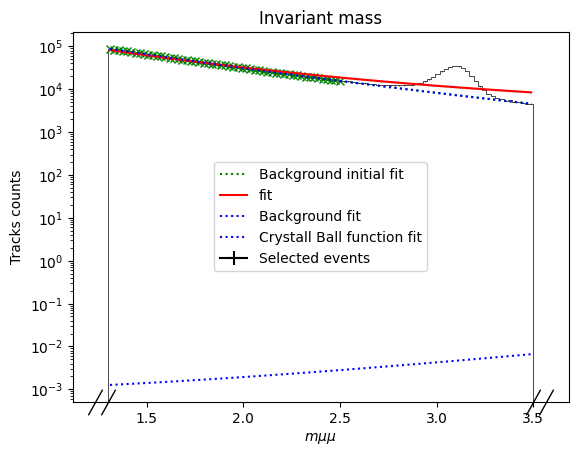

In [53]:
#vhMagRaw.plot(label="no cuts")
hminv.plot(label="Selected events",color='black',ls='-',lw=0.5)

# Initial bg fit
if 1:
    plt.plot(x[Ibg],y[Ibg],'xg')
    yfitbg = np.exp(bgDE(x,*paramsbg))
    plt.plot(x,yfitbg,':g',label="Background initial fit")
    sigmas = np.diag(covsbg)**2
    #efit = np.sqrt(np.sum(sigmas))
    #plt.fill_between(x,yfit-efit,yfit+efit,color='gray',alpha=0.2)
    
if 1:
    yfit = np.exp(fitfunc(x,*params))
    plt.plot(x,yfit,'-r',label="fit")
    sigmas = np.diag(covs)**2
    efit = np.sqrt(np.sum(sigmas))
    #plt.fill_between(x,yfit-efit,yfit+efit,color='gray',alpha=0.2)  
    plt.fill_between(x,yfit-err,yfit+err,color='gray',alpha=0.2)
    
if 1:
    yfitbg = np.exp(bgDE(x,*paramsbg[-4:]))
    plt.plot(x,yfitbg,':b',label="Background fit")
    #sigmas = np.diag(covsbg)**2
    #efit = np.sqrt(np.sum(sigmas))
    #plt.fill_between(x,yfit-efit,yfit+efit,color='gray',alpha=0.2)   

if 1:
    yfit = np.exp(crystalball(x,*params[:7]))
    plt.plot(x,yfit,':b',label="Crystall Ball function fit")    
    

plt.yscale("log")
plt.ylabel("Tracks counts")
plt.title('Invariant mass');
plt.legend();
